# Optimal Control of a crop irrigation model under water Scarcity

You may find a detailed article about this problem in the following link :
https://hal.archives-ouvertes.fr/hal-01991296v2


The goal of this study is to optimize the schedule of irrigation to maximize biomass production under the assumption of having a certain amount or Quota of water.

We consider the following crop irrigation model, where $B(t)$ stands for crop biomass at time t and $S(t)$ stands for relative sol humidity in the root zone:

$$ \dot S = k_1(-\phi(t)K_S(S)-(1-\phi(t))K_R(S)+k_2u(t))$$ 
$$ \dot B = \phi(t)K_S(S) $$

with the initial conditions: $S(0)=S_0>S_*$ and $B(0)=B_0>0$

The piecewise linear non decreasing from $[0,1]$ to $[0,1]$ functions $K_R$ and $K_S$ are defined thanks to the key constants : $S_w$ which represents the plant wilting point, $S_h$ which represents the hydroscopic point and $S_*$, the minimal threshold on the soil humidity that gives the best biomass production: 

$K_S(S)$=$\begin{cases}
0 if S \in [0,S_w] \\
\frac{S-S_w}{S_*-S_w} if S \in [0,S_w] \\
1 if S \in [S_*,1]
\end{cases}$


$K_R(S)$=$\begin{cases}
0 if S \in [0,S_h] \\
\frac{S-S_h}{1-S_h} if S \in [S_h,1]
\end{cases}$



where 0 < $S_h$ < $S_w$ < $S_*$ < 1

Therefore, our optimisation problem is:

$$max_{u(.)} \int_0^T \phi(t)K_S(S(t))$$

where $\dot V = u(t)$ and $V(0)=0$ and the target : $V(T)=\bar V=\frac{\bar Q}{F_{max}}$

[Thumbnail](image.jpg)

In [6]:
using JuMP   # NLP modelling
using Ipopt  # NLP solver
using Plots  # For plotting
using PyCall # Using python libraries

In [7]:

# Constants of the problem
T = 1                  # Duration of the irrigation
k_1 = 2.5 
k_2 = 5
S_etoile = 0.7         
S_w = 0.4
S_h = 0.2
F_max = 1.2             
alpha = 3              # Using phi(t) = t^(alpha)
S_0 = 1                # Initial soil humidity
B_0 = 0                # Initial Biomass
V_0 = 0                # Initial quantity of water
t0 = 0                 # Sowing date
tf = T                 # Harvesting date
Q_bar = 0.09           # Water Quota
V_max = Q_bar/F_max    # Terminal condition on water quota

#The evaluation of the Ks function given a point S and the two thresholds S* and Sw
function KS(S)
    res = 0
    if S>=0 && S<=S_w
        res = 0
    elseif S>=S_w && S<=S_etoile
        res = (S-S_w)/(S_etoile-S_w)
    else
        res = 1
    end
    return res      
end

KS (generic function with 1 method)

## Using Lagrange polynomial interpolation for smoothing the Ks function ##

The function $K_S$ is nonlinear, therefore we need to smooth it in order to be able to define it in the JuMP model. This smoothing uses the Lagrange polynomial interpolation method where we choose a set of points that the polynomial should interpolate. Note that the corner points of $K_S$ are very important in this optimization problem as you can see in the article presented above. Therefore, one should always include $S_w$ and $S_*$ in the set of interpolated points.

In [8]:
# Calling some useful Python libraries
np = pyimport("numpy")
Interpolate = pyimport("scipy.interpolate")
Pol = pyimport("numpy.polynomial")

# Applying the Lagrange polynomial interpolation method to the function Ks in order to make it
# usable in JuMP.

# Interpolation points
# You can choose any set of points, as long as it includes the corner points Sw and S*
x = np.array([0,0.04,0.05,0.06,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.97,0.98,0.99,1,1.001])   
y = np.array([KS(s) for s in x])

# The coefficients of the lagrange polynomial
# P = coef[d]*S + coef[d-1]*S² + ....... + coef[1]*S^d 
poly = Interpolate.lagrange(x,y)
coef = Pol.Polynomial(poly).coef
d = size(coef, 1) - 1
println("The degree of the polynomial: $(d)\n")
println("The coefficients of the polynomial :\n ")
print(coef)

The degree of the polynomial: 18

The coefficients of the polynomial :
 
[-6.383217239654541e7, 5.878971698271484e8, -2.4695480669023438e9, 6.2633767616015625e9, -1.0701879900125e10, 1.301654776675e10, -1.1611603401578125e10, 7.71526900490625e9, -3.84020989959375e9, 1.4293626976445312e9, -3.9459803530249023e8, 7.964622618457031e7, -1.1510975383407593e7, 1.1573526673231125e6, -77727.29947686195, 3276.738518975675, -77.50842254672898, 0.7779864636318052, 0.0]

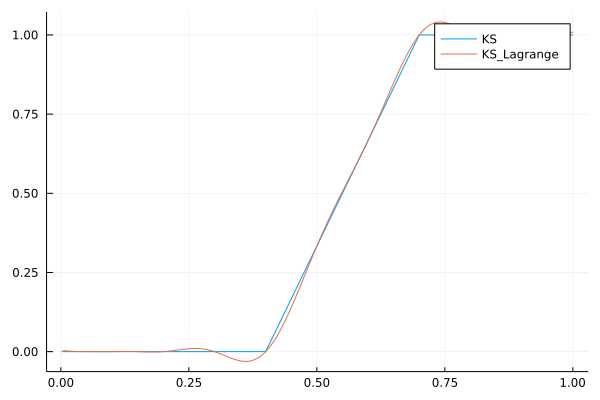

In [9]:
# The evaluation of the Lagrange version of the function Ks on a point S
function KS_lagrange(S)
    s = 0
    n = size(coef, 1)
    for i in 1:n
        s = s + coef[i]*(S^(n-i))
    end
    return s
end

# Plotting Ks and Ks_Lagrange
N = 500
Δt = 1/N 
t = (1:N) * Δt
r1 = []
r2 = []
for i in 1:N
    append!(r1, KS(t[i]))
    append!(r2, KS_lagrange(t[i]))
end
    
plot(t, r1, label="KS")
plot!(t, r2, label="KS_Lagrange")

## Solving the problem using the Ipopt solver ##

In [10]:
   # JuMP model, Ipopt solver
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => 3))
    set_optimizer_attribute(sys, "tol", 1e-9)
    set_optimizer_attribute(sys, "max_iter", 100000)
    # Parameters

    N = 100    # grid size
    Δt = (tf-t0)/N             # Time step

    f(x, y) = max(x,y)
    JuMP.register(sys, :f, 2, f, autodiff=true)

    g(x, y) = min(x,y)
    JuMP.register(sys, :g, 2, g, autodiff=true)

    JuMP.@variables(sys, begin
        0. ≤ s[1:N] ≤ 1.       # s : soil humidty
        0. ≤ V[1:N] ≤ V_max    # V
        0. ≤ b[1:N] ≤ 1.       # B
        0. ≤ u[1:N] ≤ 1.       # allocation (control)
    end)


    # Objective
    @objective(sys, Max, b[N])

    # Initial conditions
    @constraints(sys, begin
        s[1] == S_0
        V[1] == V_0
        b[1] == B_0
        #V[N] == V_max
    end)



    # Dynamics
    @NLexpression(sys, ph[j = 1:N], (j*Δt)^alpha)
    @NLexpression(sys, Kr[j = 1:N], g(1, f(0,(s[j]-S_h)/(1-S_h))) )
    # A polynomial approxmation of Ks using Lagrange interpolation
    # P = coef[d]*S + coef[d-1]*S² + ....... + coef[1]*S^d 
    @NLexpression(sys, Ks[j = 1:N], coef[d]*s[j] + coef[d-1]*(s[j]^2) + coef[d-2]*(s[j]^3) + coef[d-3]*(s[j]^4) 
                                  + coef[d-4]*(s[j]^5) + coef[d-5]*(s[j]^6) + coef[d-6]*(s[j]^7) + coef[d-7]*(s[j]^8) 
                                  + coef[d-8]*(s[j]^9) + coef[d-9]*(s[j]^10) + coef[d-10]*(s[j]^11) + coef[d-11]*(s[j]^12) 
                                  + coef[d-12]*(s[j]^13) + coef[d-13]*(s[j]^14) + coef[d-14]*(s[j]^15) + coef[d-15]*(s[j]^16)
                                  + coef[d-16]*(s[j]^17) + coef[d-17]*(s[j]^18) )
  
    for j in 1:N-1
        @NLconstraint(sys, s[j+1] == s[j] +  Δt * k_1*(-ph[j]*Ks[j] - (1-ph[j])*Kr[j] + k_2*u[j]))
        @NLconstraint(sys, b[j+1] == b[j] +  Δt * ph[j]*Ks[j])
        @NLconstraint(sys, V[j+1] == V[j] +  Δt * u[j])
    end


    #Solve for the control and state
    #println("Solving...")
    status = optimize!(sys)
    #println("Solver status: ", status)
    s1 = value.(s)
    b1 = value.(b)
    V1 = value.(V)
    u1 = value.(u)
    println("Cost: ", objective_value(sys))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:      300
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 81

     

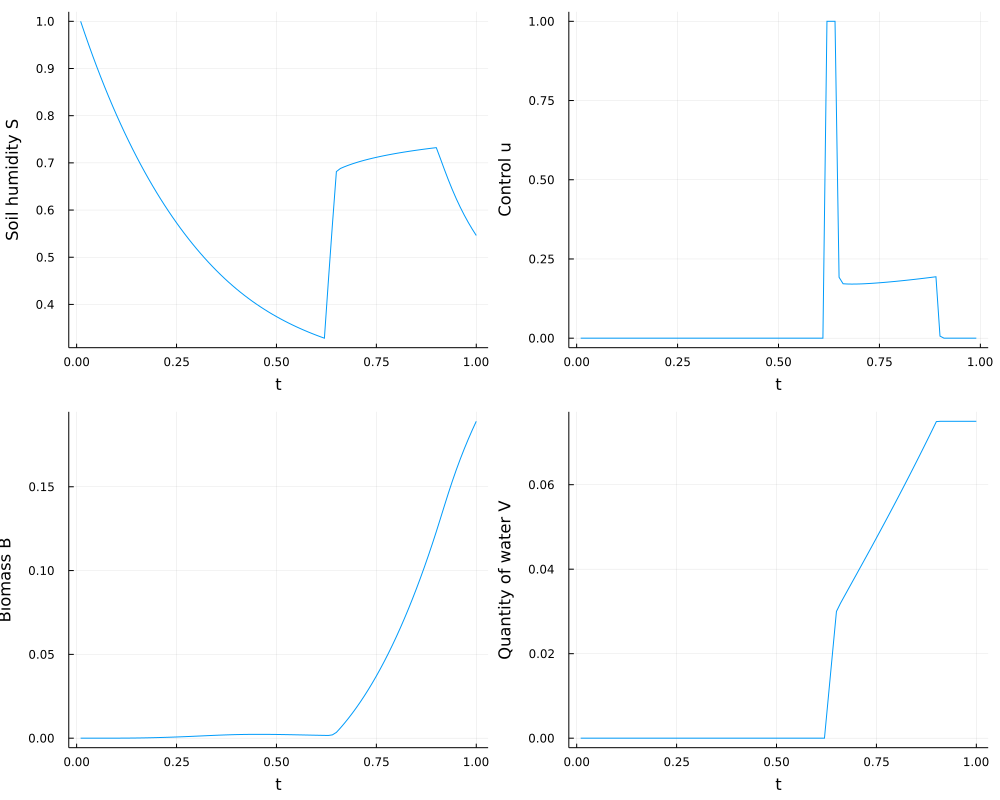

In [11]:
t = (1:N) * Δt
s_plot = plot(t, s1, xlabel = "t", ylabel = "Soil humidity S", legend = false, fmt = :png)
u_plot = plot(t[1:N-1], u1[1:N-1], xlabel = "t", ylabel = "Control u", legend = false, fmt = :png)
b_plot = plot(t, b1, xlabel = "t", ylabel = "Biomass B", legend = false, fmt = :png)
v_plot = plot(t, V1, xlabel = "t", ylabel = "Quantity of water V", legend = false, fmt = :png)
display(plot(s_plot, u_plot, b_plot, v_plot, layout = (2, 2), size=(1000,800)))